# GMM Training on DistilHuBERT Layer Features
GMM model on concatenated outputs from the first three layers of the fine-tuned DistilHuBERT model (step1)
* 1000 batch

In [1]:
import sys
sys.executable

import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
import os
import torch
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from transformers import AutoProcessor, AutoModel
from datasets import load_dataset, Audio
from train_classifier import extract_all_layer_features
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained("/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/checkpoints_distilhubert_asr/final_model").to(device)
processor = AutoProcessor.from_pretrained("/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/checkpoints_distilhubert_asr/final_model")

In [4]:
dataset = load_dataset("audiofolder", 
                       data_dir="/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/data/LibriSpeech/train-other-500")["train"]
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Resolving data files:   0%|          | 0/151472 [00:00<?, ?it/s]

In [6]:
'''
# Test
small_dataset = load_dataset(
    "audiofolder",
    data_dir="/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/data/LibriSpeech/train-other-500/3885"
)["train"]

print("Loaded dataset:", len(small_dataset))
print("Example:", small_dataset[0])

# Ensure 16kHz sampling rate
small_dataset = small_dataset.cast_column("audio", Audio(sampling_rate=16000))

# Feature extraction
all_features = []
for example in small_dataset:
    waveform = processor(example["audio"]["array"], sampling_rate=16000, return_tensors="pt").input_values.to(device)
    feats = extract_all_layer_features(model, waveform, layers=[0, 1, 2])
    all_features.append(feats.squeeze(0).cpu().numpy())  # [T, D]

all_feats = np.vstack(all_features)  # [total_T, 2304]
print("Combined feature shape:", all_feats.shape)

# Standardize + PCA to 256 dims
scaler = StandardScaler()
pca = PCA(n_components=256)

all_feats_scaled = scaler.fit_transform(all_feats)
all_feats_pca = pca.fit_transform(all_feats_scaled)

# Fit GMM
gmm = GaussianMixture(n_components=500, covariance_type="diag", reg_covar=1e-2, max_iter=100, verbose=1)
gmm.fit(all_feats_pca)

# Get soft posteriors on a sample
test_feats = extract_all_layer_features(model, waveform, layers=[0, 1, 2]).squeeze(0).cpu().numpy()
test_feats_scaled = scaler.transform(test_feats)
test_feats_pca = pca.transform(test_feats_scaled)
posterior_probs = gmm.predict_proba(test_feats_pca)

print("Posterior shape:", posterior_probs.shape)
print("First posterior (rounded):", np.round(posterior_probs[5], 3))
'''

Resolving data files:   0%|          | 0/178 [00:00<?, ?it/s]

Loaded dataset: 173
Example: {'audio': {'path': '/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/data/LibriSpeech/train-other-500/3885/1193/3885-1193-0000.flac', 'array': array([ 0.00021362,  0.00024414,  0.00027466, ..., -0.00094604,
       -0.00094604, -0.00106812]), 'sampling_rate': 16000}, 'label': 0}
Combined feature shape: (73978, 2304)
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
Initialization converged.
Posterior shape: (192, 500)
First posterior (rounded): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Entropy: Mean = 0.0026, Std = 0.0107


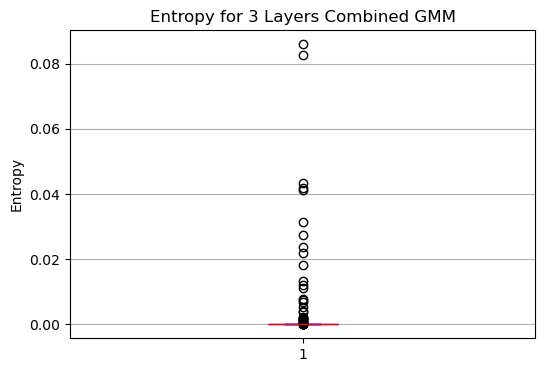

In [12]:
'''
# Compute entropy
entropy = -np.sum(posterior_probs * np.log(posterior_probs + 1e-8), axis=1)
print(f"Entropy: Mean = {entropy.mean():.4f}, Std = {entropy.std():.4f}")

plt.figure(figsize=(6, 4))
plt.boxplot(entropy, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'))
plt.ylabel("Entropy")
plt.title("Entropy for 3 Layers Combined GMM")
plt.grid(axis='y')
plt.show()
'''

#### Full dataset

In [5]:
'''
# Paths
save_path = "/scratch/pippalin2/jupyter/GMM-DistilHuBERT/script/train_classifier/"
checkpoint_dir = os.path.join(save_path, "save_pathgmm_checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# Settings
batch_size = 32
pca_dim = 256

# Resume checkpoint
batch_start = 0
if os.path.exists(os.path.join(checkpoint_dir, "checkpoint_batch.txt")):
    with open(os.path.join(checkpoint_dir, "checkpoint_batch.txt"), "r") as f:
        batch_start = int(f.read().strip())

if batch_start == 0:
    scaler = StandardScaler()
    pca = IncrementalPCA(n_components=pca_dim)
else:
    scaler = joblib.load(os.path.join(checkpoint_dir, "scaler.pkl"))
    pca = joblib.load(os.path.join(checkpoint_dir, "pca.pkl"))

# First pass: incrementally fit scaler and PCA
print(f"First pass: Resuming from dataset index {batch_start} (batch #{batch_start // batch_size})")
for i in tqdm(range(batch_start, len(dataset), batch_size)):
    # Save progress BEFORE processing the batch
    with open(os.path.join(checkpoint_dir, "checkpoint_batch.txt"), "w") as f:
        f.write(str(i))

    batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
    batch_feats = []

    with torch.no_grad():
        for example in batch:
            waveform = processor(example["audio"]["array"], sampling_rate=16000, return_tensors="pt").input_values.to(device)
            feats = extract_all_layer_features(model, waveform, layers=[0, 1, 2])
            batch_feats.append(feats.squeeze(0).cpu().numpy())

    X_batch = np.vstack(batch_feats)

    # Faster: don't transform during first pass
    scaler.partial_fit(X_batch)
    pca.partial_fit(X_batch)

    joblib.dump(scaler, os.path.join(checkpoint_dir, "scaler.pkl"))
    joblib.dump(pca, os.path.join(checkpoint_dir, "pca.pkl"))
'''

First pass: Resuming from dataset index 124256 (batch #3883)


100%|███████████████████████████████████████| 764/764 [2:44:57<00:00, 12.95s/it]

First pass complete. Scaler and PCA are now trained.


In [ ]:
'''
# Clean up
if os.path.exists(os.path.join(checkpoint_dir, "checkpoint_batch.txt")):
    os.remove(os.path.join(checkpoint_dir, "checkpoint_batch.txt"))

print("First pass complete. Scaler and PCA are now trained.")
'''

In [ ]:
joblib.dump(gmm, save_path+"gmm_model.pkl")
joblib.dump(scaler, save_path+"gmm_scaler.pkl")
joblib.dump(pca, save_path+"gmm_pca.pkl")
print("Saved GMM, scaler, and PCA.")

In [ ]:
# Cell 7: Save Soft Labels for Debugging/Inspection
soft_labels = gmm.predict_proba(all_features)
np.save(save_path+"soft_labels.npy", soft_labels)